# **Scraping ESPN NBA data**

In [1]:
import os  # For operating system related functionality
import json  # For working with JSON data
from datetime import datetime  # For working with dates and times
from tqdm import tqdm  # For displaying progress bars
import pandas as pd  # For working with dataframes
from bs4 import BeautifulSoup  # For web scraping
import requests  # For making HTTP requests

def get_soup(url):
    """
    Returns a BeautifulSoup object for the given URL.
    """
    page = requests.get(url, headers={'User-agent': 'your bot 0.1'})
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

# Constant for base URL
base_url = 'https://www.espn.com/'

## 1. Get the list of teams

In [2]:
def get_teams_df():
    # return teams dataframe if exists or scrape and save to parquet
    if os.path.exists('data/teams.parquet'):
        return pd.read_parquet('data/teams.parquet')

    url = 'https://www.espn.com/nba/teams'
    soup = get_soup(url)

    team_data = []
    for team in soup.find_all('section', class_='TeamLinks flex items-center'):
        team_data.append({
            'name': team.find('a').find('img')['alt'],
            'tag': team.find('a')['href'].split('/')[-1],
            'code': team.find('a')['href'].split('/')[-2],
            'url': team.find('a')['href']
        })

    teams_df = pd.DataFrame(team_data)
    # save to parquet
    teams_df.to_parquet('data/teams.parquet')

    return teams_df

get_teams_df().head()

,name,tag,code,url,bref_url,bref_code
0,Atlanta Hawks,atlanta-hawks,atl,/nba/team/_/name/atl/atlanta-hawks,/teams/ATL/2023.html,ATL
1,Boston Celtics,boston-celtics,bos,/nba/team/_/name/bos/boston-celtics,/teams/BOS/2023.html,BOS
2,Brooklyn Nets,brooklyn-nets,bkn,/nba/team/_/name/bkn/brooklyn-nets,/teams/BRK/2023.html,BRK
3,Charlotte Hornets,charlotte-hornets,cha,/nba/team/_/name/cha/charlotte-hornets,/teams/CHO/2023.html,CHO
4,Chicago Bulls,chicago-bulls,chi,/nba/team/_/name/chi/chicago-bulls,/teams/CHI/2023.html,CHI


## 2. Get the schedule for a single team

In [3]:
def get_schedule(team_code: str, team_tag: str, year: int = 2023) -> list:
    """Get schedule for a team in a given year
    Args:
        team_code (str): 3 letter team code. Example: 'atl'
        team_tag (str): team tag. Example: 'atlanta-hawks'
        year (int, optional): year. Example: 2023 means 2022-2023 season.
    Returns:
        list: list of dictionaries with schedule data
    """

    url = f'https://www.espn.com/nba/team/schedule/_/name/{team_code}/season/{year}/seasontype/2'
    soup = get_soup(url)
    game_list = soup.find('table').find_all('tr')[1:]
    schedule_data = []
    for game in game_list:
        tds = game.find_all('td')
        schedule_data.append({
            # datetime.strptime('Wed, Oct 19', '%a, %b %d')
            'date': tds[0].text,
            'datetime': datetime.strptime(tds[0].text, '%a, %b %d'),
            'is_home': tds[1].text.split(' ')[0] == 'vs',
            'result': tds[2].text[0],
            'scores': tds[2].text[1:].strip().split(' ')[0].split('-'),
            'OT': tds[2].text.strip()[-1] == 'T',
            'game_url': tds[2].find('a')['href'].split('.com/')[1] if tds[2].find('a') else None,
            'schedule_of': team_tag,
            'openent': tds[1].find('a')['href'].split('/')[-1],
        })
    return schedule_data

In [4]:
def transform_schedule(schedule_data):
    df = pd.DataFrame(schedule_data)
    df['datetime'] = df['datetime'].apply(lambda x: x.replace(year=2022) if x.month >= 10 else x.replace(year=2023))
    return df

transform_schedule(get_schedule('atl', 'atlanta-hawks')).head()

,date,datetime,is_home,result,scores,OT,game_url,schedule_of,openent
0,"Wed, Oct 19",2022-10-19,True,W,"[117, 107]",False,nba/game/_/gameId/401468020,atlanta-hawks,houston-rockets
1,"Fri, Oct 21",2022-10-21,True,W,"[108, 98]",False,nba/game/_/gameId/401468175,atlanta-hawks,orlando-magic
2,"Sun, Oct 23",2022-10-23,True,L,"[126, 109]",False,nba/game/_/gameId/401468193,atlanta-hawks,charlotte-hornets
3,"Wed, Oct 26",2022-10-26,False,W,"[118, 113]",False,nba/game/_/gameId/401468212,atlanta-hawks,detroit-pistons
4,"Fri, Oct 28",2022-10-28,False,W,"[136, 112]",False,nba/game/_/gameId/401468225,atlanta-hawks,detroit-pistons


## 3. Get the schedule for all teams

In [5]:
def get_schedule_df(year: int = 2023) -> pd.DataFrame:
    if os.path.exists('data/schedule.parquet'):
        return pd.read_parquet('data/schedule.parquet')

    # get the schedule for each team
    schedule_data = []
    for index, row in tqdm(team_df.iterrows(), total=team_df.shape[0]):
        schedule_data.extend(get_schedule(row['code'], row['tag'], year))
        
    schedule_df = pd.DataFrame(schedule_data)
    schedule_df['datetime'] = schedule_df['datetime'].apply(lambda x: x.replace(year=2022) if x.month >= 10 else x.replace(year=2023))

    # Drop the away games
    schedule_df = schedule_df[schedule_df['is_home'] == True]

    # Save home and away scores
    schedule_df['home_score'] = schedule_df.apply(lambda x: x['scores'][0] if x['result'] == 'W' else x['scores'][-1], axis=1)
    schedule_df['away_score'] = schedule_df.apply(lambda x: x['scores'][-1] if x['result'] == 'W' else x['scores'][0], axis=1)

    # Drop unnecessary columns
    schedule_df = schedule_df.drop(columns=['is_home', 'date', 'scores'])

    # Rename columns
    schedule_df.columns = ['date', 'home_win', 'OT', 'url', 'home_team', 'away_team', 'home_score', 'away_score']

    # Drop rows with duplicate urls (caused by neutral site games)
    schedule_df.drop_duplicates(subset=['url'], inplace=True)

    # Drop rows with nans
    schedule_df.dropna(inplace=True)

    # Check that there are 30 teams and 82 games per team
    assert schedule_df.shape[0] == 30 * 82 / 2
    
    # Save to parquet
    schedule_df.to_parquet('data/schedule.parquet')

    return schedule_df

get_schedule_df().head()

,date,home_win,OT,url,home_team,away_team,home_score,away_score
0,2022-10-18,W,False,nba/game/_/gameId/401468016,boston-celtics,philadelphia-76ers,126,117
4,2022-10-28,L,True,nba/game/_/gameId/401468227,boston-celtics,cleveland-cavaliers,123,132
5,2022-10-30,W,False,nba/game/_/gameId/401468244,boston-celtics,washington-wizards,112,94
7,2022-11-04,W,False,nba/game/_/gameId/401468279,boston-celtics,chicago-bulls,123,119
10,2022-11-09,W,False,nba/game/_/gameId/401468318,boston-celtics,detroit-pistons,128,112


## 4. List of players per team

In [6]:
def get_bref_teams(year: int = 2023) -> pd.DataFrame:
    if os.path.exists('data/bref_teams.parquet'):
        return pd.read_parquet('data/bref_teams.parquet')

    soup = get_soup(f'https://www.basketball-reference.com/leagues/NBA_{year}_standings.html')
    all_tables = soup.find_all('table')
    print(len(all_tables))
    bref_teams = []
    for table in all_tables[:2]:
        for team in table.find_all('a'):
            bref_teams.append({
                'name': team.text,
                'bref_url': team['href'],
                'bref_code': team['href'].split('/')[-2],
            })
    bref_teams_df = pd.DataFrame(bref_teams)
    bref_teams_df.to_parquet('data/bref_teams.parquet')
    return bref_teams_df

In [7]:
def fix_teams_df(check=False):
    "Run if teams_df doesn't have bref columns"
    if check:
        teams_df = get_teams_df()
        bref_teams_df = get_bref_teams()

        teams_df = teams_df.sort_values('name').reset_index(drop=True)
        teams_df.loc[teams_df['name'] == 'LA Clippers', 'name'] = 'Los Angeles Clippers'
        teams_df.loc[teams_df['name'] == 'LA Clippers', 'tag'] = 'los-angeles-clippers'
        teams_df = teams_df.merge(bref_teams_df, left_on='name', right_on='name', how='outer')
        teams_df.to_parquet('data/teams.parquet')
    else:
        print('Set check=True to run this function. Check whether teams_df has bref columns.')

fix_teams_df()

Set check=True to run this function. Check whether teams_df has bref columns.


In [8]:
def get_players_df(year: int = 2023) -> pd.DataFrame:
    if os.path.exists('data/players.pkl'):
        return pd.read_pickle('data/players.pkl')
    
    teams_df = get_teams_df()
    players = []
    for team_code in tqdm(teams_df['bref_code']):
        roster = pd.read_html(f'https://www.basketball-reference.com/teams/{team_code.upper()}/{year}.html')[0]
        roster.rename(columns={'Unnamed: 6': 'Origin'}, inplace=True)
        roster['bref_code'] = team_code
        players.extend(roster.values.tolist())

    players_df = pd.DataFrame(players)
    players_df.columns = ['Number', 'Name', 'Pos', 'Height', 'Weight', 'Birth Date', 'Origin', 'Exp', 'College', 'bref_code']

    players_df.to_pickle('data/players.pkl')
    return players_df

get_players_df().head()

,Number,Name,Pos,Height,Weight,Birth Date,Origin,Exp,College,bref_code
0,41,Saddiq Bey,SF,6-7,215,"April 9, 1999",us,2,Villanova,ATL
1,13,Bogdan Bogdanović,SG,6-6,220,"August 18, 1992",rs,5,NaN,ATL
2,15,Clint Capela,C,6-10,240,"May 18, 1994",ch,8,NaN,ATL
3,20,John Collins,PF,6-9,235,"September 23, 1997",us,5,Wake Forest,ATL
4,7,Jarrett Culver,SF,6-6,195,"February 20, 1999",us,3,Texas Tech,ATL


## 5. Get the "play-by-play" for a single game

In [9]:
schedule_df = get_schedule_df()

# Example game url. Click on the url to see the game details :)
print(f'The game we are going to work on is {schedule_df.iloc[-1]["home_team"]} vs {schedule_df.iloc[-1]["away_team"]}')
url = 'nba/game/_/gameId/401361018'
print(f'URL: {base_url}{url}')

The game we are going to work on is san-antonio-spurs vs minnesota-timberwolves
URL: https://www.espn.com/nba/game/_/gameId/401361018


In [10]:
# You access play-by-play by changing '/game/' to '/playbyplay/' in the url
print(f'The play-by-play url is:')
print(f'{base_url}{url.replace("/game/", "/playbyplay/")}')

The play-by-play url is:
https://www.espn.com/nba/playbyplay/_/gameId/401361018


In [149]:
def get_playbyplay(game_url: str):
    """Gets play-by-play data for a given game url.
    Args:
        game_url (str): url of the game. Example: '/nba/game/_/gameId/401267260'"""

    soup = get_soup(base_url + game_url.replace('/game/', '/playbyplay/'))
    
    # A weird ass script tag that has all the data
    text = soup.find_all('script')[-5].text

    text = text.split('playGrps')[1].split('}]],')[0] + '}]]'
    data = json.loads(text[2:])
    # flatten list
    # df = [item for sublist in data for item in sublist]
    df = pd.DataFrame([item for sublist in data for item in sublist])
    df['period'] = df['period'].apply(lambda x: x['number'])
    df['clock'] = df['clock'].apply(lambda x: x['displayValue'])
    df['text'] = df['text'].fillna(' ')
    return df

playbyplay_df = get_playbyplay(url)
playbyplay_df

,id,period,text,homeAway,awayScore,homeScore,clock,scoringPlay
0,4013610184,1,Jakob Poeltl vs. Karl-Anthony Towns (Tre Jones...,away,0,0,12:00,NaN
1,4013610187,1,Devin Vassell misses 14-foot pullup jump shot,away,0,0,11:39,NaN
2,4013610188,1,Patrick Beverley defensive rebound,home,0,0,11:36,NaN
3,4013610189,1,Anthony Edwards makes driving layup,home,0,2,11:24,True
4,40136101810,1,Jakob Poeltl misses two point shot,away,0,2,11:08,NaN
...,...,...,...,...,...,...,...,...
518,401361018739,4,Karl-Anthony Towns makes free throw 2 of 2,home,121,127,3.5,True
519,401361018740,4,Joshua Primo misses 26-foot three point shot,away,121,127,1.1,NaN
520,401361018741,4,Spurs offensive team rebound,away,121,127,1.0,NaN
521,401361018742,4,End of the 4th Quarter,NaN,121,127,0.0,NaN


In [150]:
def add_player_names(playbyplay_df, team_tags):
    """
    Adds a column with player names to the playbyplay_df.
    Args:
        playbyplay_df (pd.DataFrame): playbyplay dataframe
        team_tags (list): list of team tags. Example: ['atlanta-hawks', 'charlotte-hornets']
    """
    players_df = get_players_df()
    teams_df = get_teams_df()

    # Get the set of players that played in the teams
    player_set = set(players_df.loc[players_df['bref_code'].isin(teams_df.loc[teams_df['tag'].isin(team_tags), 'bref_code']), 'Name'])
    playbyplay_df['player_names'] = playbyplay_df['text'].apply(lambda x: [name for name in player_set if name in x])
    # Sort the names by their position in the text
    playbyplay_df['player_names'] = playbyplay_df.apply(lambda x: [name for name, start in 
                    sorted([(name, re.search(name, x['text']).start()) for name in x['player_names']], key=lambda x: x[1])], axis=1)

    return playbyplay_df

playbyplay_df = add_player_names(playbyplay_df, schedule_df.loc[2460, ['home_team', 'away_team']])
playbyplay_df.head()

,id,period,text,homeAway,awayScore,homeScore,clock,scoringPlay,player_names
0,4013610184,1,Jakob Poeltl vs. Karl-Anthony Towns (Tre Jones...,away,0,0,12:00,NaN,"[Jakob Poeltl, Karl-Anthony Towns, Tre Jones]"
1,4013610187,1,Devin Vassell misses 14-foot pullup jump shot,away,0,0,11:39,NaN,[Devin Vassell]
2,4013610188,1,Patrick Beverley defensive rebound,home,0,0,11:36,NaN,[]
3,4013610189,1,Anthony Edwards makes driving layup,home,0,2,11:24,True,[Anthony Edwards]
4,40136101810,1,Jakob Poeltl misses two point shot,away,0,2,11:08,NaN,[Jakob Poeltl]


## 6. Finding the play in the video
We are going to look at the last game of the year.

In [13]:
schedule_df.iloc[-1]

date                  2023-04-08 00:00:00
home_win                                L
OT                                  False
url           nba/game/_/gameId/401469369
home_team               san-antonio-spurs
away_team          minnesota-timberwolves
home_score                            131
away_score                            151
Name: 2460, dtype: object

I have dowloaded this video [Spurs @ Timberwolves](https://basketball-video.com/san-antonio-spurs-vs-minnesota-timberwolves-full-game-replay-apr-7-2021-nba-replay-hd). It also says it is broadcasted on local TV: BSN, BSSW-SA:
* BSN stands for Bally Sports North
* BSSW-SA stands for Bally Sports Southwest - San Antonio

Here's the [list of NBA broadcasters by Wikipedia](https://en.wikipedia.org/wiki/List_of_current_National_Basketball_Association_broadcasters)

In [14]:
# !pip install opencv-python
import cv2
import random
from IPython.display import display, Image
from PIL import Image as ImagePIL
import pytesseract 

# ALSO INSTALL TESSERACT ON YOUR MACHINE
# For Mac: brew install tesseract
# For Windows: https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i

# Video path videos/spurs@timberwolves.mp4

Total frames: 280556, Frame number: 56111
Success: True, image shape: (360, 640, 3)


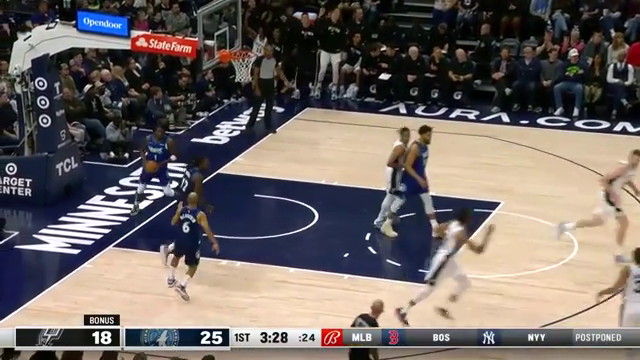

In [15]:
# Read video
vidcap = cv2.VideoCapture('videos/spurs@timberwolves.mp4')

# Get total number of frames
total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

# I selected the denomonator 5 so that we can see the scoreboard.
frame_number = total_frames // 5
print(f'Total frames: {total_frames}, Frame number: {frame_number}')

# Set frame number
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read frame
success, image = vidcap.read()
print(f'Success: {success}, image shape: {image.shape}')

# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', image)
    display(Image(data=img_encoded))
else:
    print('Error: Could not read frame')

In [16]:
# Read frame
success, image = vidcap.read()
print(f'Height is {image.shape[0]}, cropping between 91% and 96%')
image = image[int(image.shape[0] * 0.91):int(image.shape[0] * 0.96)]

# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', image)
    display(Image(data=img_encoded))

print(f'Width is {image.shape[1]}, cropping between 36% and 50%')
image = image[:, int(image.shape[1] * 0.36):int(image.shape[1] * 0.5)]

# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', image)
    display(Image(data=img_encoded))

Height is 360, cropping between 91% and 96%


Width is 640, cropping between 36% and 50%


In [17]:
def ocr(image):
    whitelist_chars = '0123456789 :STNDRDTH'
    return pytesseract.image_to_string(ImagePIL.fromarray(image), lang='eng', config=f'--psm 7 --oem 3 -c tessedit_char_whitelist="{whitelist_chars}"')

In [18]:
print(f'OCR on the cropped image: {ocr(image)}')
import numpy as np
# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', image)
    display(Image(data=img_encoded))

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(f'Applied grayscale, previous shape: {image.shape}, new grayscale shape: {gray.shape}')
print(f'OCR on the cropped image: {ocr(gray)}')

# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', gray)
    display(Image(data=img_encoded))

# Apply gaussian thresholding: ADAPTIVE_THRESH_GAUSSIAN_C
thresh2 = cv2.adaptiveThreshold(gray, np.max(gray),
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
print('Applied gaussian thresholding, OCR: ', ocr(thresh2))

# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', thresh2)
    display(Image(data=img_encoded))

OCR on the cropped image: 1ST 3:28 :24



Applied grayscale, previous shape: (18, 90, 3), new grayscale shape: (18, 90)
OCR on the cropped image: 1ST 3:28 :24



Applied gaussian thresholding, OCR:  1ST 3:28 :24



The global thresholding sucks. Let's see if there is a compuational difference between original, grayscale and thresholded images.

In [275]:
# Let's time OCR on different image processing methods (timeit)
%timeit ocr(image)
%timeit ocr(gray)
%timeit ocr(thresh2)

205 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
194 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
178 ms ± 6.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


They are not crazy far off from each other. Let's stick with grayscale for now. What if I crop the image to 3 pieces?

## 7. Finding the play in the video

In [200]:
import numpy as np

def get_game_time(success: bool, image: np.ndarray, check_grayscale: bool = True, verbose: bool = True):
    """Returns the game time from the scoreboard image. The format is (period, minutes, seconds)."""
    
    if not success:
        print('Error: Could not read frame') if verbose else None
        return -1
    image = image[int(image.shape[0] * 0.91):int(image.shape[0] * 0.96), # Crop top and bottom
                  int(image.shape[1] * 0.36):int(image.shape[1] * 0.5)]  # Crop left and right
    # grayscale
    gt = ocr(image).strip().split()

    if len(gt) != 3 and len(gt) != 2:
        print(f'Error: Could not read game time (list length is not 3 or 2) {gt}') if verbose else None
        print(gt) if verbose else None
        return -1

    if check_grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gt_gray = ocr(image).strip().split()
        if gt != gt_gray:
            print('Grayscale and color OCR do not match') if verbose else None
            print(gt) if verbose else None
            print(ocr(image).strip().split()) if verbose else None
            if len(gt_gray) == 3 and gt[0][0] == gt_gray[0][0] and gt[1] == gt_gray[1]:
                print('I have let this slide because only the seconds are different') if verbose else None
            else:
                print('Error: Grayscale and color OCR do not match') 
                print(gt, gt_gray)
                return -1

    try:
        period = int(gt[0][0])
        if gt[1][0] == ':': # this is when 0 minutes remaining only seconds are shown
            minutes = 0
            seconds = int(gt[1][1:3])
        else:
            minutes = int(gt[1].split(':')[0])
            seconds = int(gt[1].split(':')[1])
    except:
        print('Length of gt is 3 or 2 but could not convert to int')
        print(gt)
        return -1
    
    return period, minutes, seconds

print(f'Game time: {get_game_time(*vidcap.read())}')

Game time: (4, 0, 9)


In [201]:
# del vidcap, frame_number, total_frames, image, gray, thresh, thresh2, img_encoded, success

In [202]:
# Read video
vidcap = cv2.VideoCapture('videos/spurs@timberwolves.mp4')

# Test everthing again
frame_number = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)) // 5

# Set frame number
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Game time
print(f'Game time: {get_game_time(*vidcap.read())}')
del vidcap, frame_number

Game time: (1, 3, 28)


To search for a play given the **game time** and **period**,
1. we will randomly select a frame,
2. we will try to read the time and period from the frame,
3. if the time and period is readable, we will update the left and right bounds of the frame,
4. if it is not readable, we will try another frame.

In [203]:
def gameclock2seconds(period, minutes, seconds):
    return (period - 1) * 12 * 60 + (11 - minutes) * 60 + (60 - seconds)

def get_played_secs(row):
    target_gt = row[['period', 'clock']].tolist()
    
    if ':' in target_gt[1]:
        target_gt.append(int(target_gt[1].split(':')[0]))
        target_gt.append(int(target_gt[1].split(':')[1]))
        # remove 1st element
        target_gt.pop(1)
        return gameclock2seconds(target_gt[0], target_gt[1], target_gt[2])
    else:
        print('Only seconds are shown', target_gt[0], int(float(target_gt[1])))
        return gameclock2seconds(target_gt[0], 0, int(float(target_gt[1])))

In [204]:
anthony_edwards_plays = playbyplay_df.loc[playbyplay_df['text'].apply(lambda x: 'Anthony Edwards' == x[:len('Anthony Edwards')] if len(x) > len('Anthony Edwards') else False) & # Anthony Edwards plays
                                          (playbyplay_df['scoringPlay'] == True) & # Scoring plays
                                            (playbyplay_df['period'] <= 4) # First 4 quarters
                                          ].copy() # Scoring plays
anthony_edwards_plays['played_secs'] = anthony_edwards_plays.apply(lambda x: get_played_secs(x), axis=1)
anthony_edwards_plays['frame'] = None
print(f'Number of plays: {anthony_edwards_plays.shape[0]}')
anthony_edwards_plays.head()

Only seconds are shown 3 23
Only seconds are shown 4 9
Only seconds are shown 4 9
Number of plays: 27


,id,period,text,homeAway,awayScore,homeScore,clock,scoringPlay,player_names,played_secs,frame
3,4013610189,1,Anthony Edwards makes driving layup,home,0,2,11:24,True,[Anthony Edwards],36,None
6,40136101813,1,Anthony Edwards makes 6-foot two point shot,home,0,4,10:42,True,[Anthony Edwards],78,None
35,40136101848,1,Anthony Edwards makes driving layup,home,4,8,8:12,True,[Anthony Edwards],228,None
40,40136101856,1,Anthony Edwards makes step back jumpshot (Jarr...,home,6,14,7:18,True,[Anthony Edwards],282,None
74,401361018110,1,Anthony Edwards makes two point shot (Jordan M...,home,17,21,4:17,True,"[Anthony Edwards, Jordan McLaughlin]",463,None


In [205]:
def get_left_right_frames(target_sec, search_df):
    # if the fram already exists, return it
    if search_df['played_secs'].isin([target_sec]).any():
        frame = search_df.loc[search_df['played_secs'] == target_sec, 'frame_number'].values[0]
        return frame, frame
    l_frame = search_df.loc[search_df['played_secs'] < target_sec, 'frame_number'].max()
    r_frame = search_df.loc[search_df['played_secs'] > target_sec, 'frame_number'].min()
    return l_frame, r_frame

In [206]:
def find_random_game_frame(vidcap, l_frame, r_frame, verbose: bool = True):
    gt = -1; total_iters = 0
    
    while gt == -1:
        # Randomly select a frame
        frame_number = random.randint(l_frame, r_frame)

        # Set frame number
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read frame
        success, image = vidcap.read()

        # Get game time
        gt = get_game_time(success, image, verbose=False, check_grayscale=False)

        # Get played seconds
        if gt != -1:
            played_secs = gameclock2seconds(*gt)
            print(f'Found a frame with seconds: {played_secs}, frame number: {frame_number}') if verbose else None
            if verbose:
                print(f'Game time: {gt}, played seconds: {played_secs}, frame number: {frame_number}') if verbose else None
                _, img_encoded = cv2.imencode('.png', image)
                display(Image(data=img_encoded))
    
        total_iters += 1

    print(f'Total iterations: {total_iters}') if verbose else None

    # Return the game time
    return gt, frame_number, played_secs, total_iters

def find_frame(vidcap, search_df, l_frame, r_frame, target_played_seconds, maxiter: int = 100, verbose: bool = True):

    # Initialize the left and right frames
    played_secs = -299
    frame_number = -1
    total_iters = 0
    while played_secs != target_played_seconds:

        if verbose:
            print(f'Left frame: {l_frame}, Right frame: {r_frame}')

        gt, frame_number, played_secs, iters = find_random_game_frame(vidcap, l_frame, r_frame, verbose=False)
        data = {
            'frame_number': frame_number,
            'played_secs': played_secs,
            'gt': gt
        }

        # search_df = search_df.append(data, ignore_index=True)
        search_df = pd.concat([search_df, pd.DataFrame([data])])
        search_df.sort_values(['played_secs', 'frame_number'], inplace=True, ignore_index=True)
        
        # drop false values
        search_df = search_df[search_df['frame_number'].diff().fillna(1).gt(0)]

        # get left and right frames
        l_frame, r_frame = get_left_right_frames(target_played_seconds, search_df)

        total_iters += iters
        if total_iters > maxiter:
            print(f'Error: Could not find the frame in {maxiter} iterations')
            return -1, search_df
        
    print(f'Total iterations: {total_iters}')
    
    return frame_number, search_df

In [207]:
# Read video
vidcap = cv2.VideoCapture('videos/spurs@timberwolves.mp4')


In [210]:
# Read video
vidcap = cv2.VideoCapture('videos/spurs@timberwolves.mp4')

# Get total number of frames
total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

search_df = pd.DataFrame([{'frame_number': 10*60*30,'played_secs': 0,'gt': (1, 12, 0)},
                          {'frame_number': 44*60*30,'played_secs': 12*60,'gt': (2, 12, 0)},
                          {'frame_number': 88*60*30,'played_secs': 2*12*60,'gt': (3, 12, 0)},
                          {'frame_number': total_frames - 1, 'played_secs': 4*12*60,'gt': (4, 0, 0)}])

In [211]:
for index, row in (pbar := tqdm(anthony_edwards_plays.iterrows(), total=anthony_edwards_plays.shape[0])):
    
    target_sec = row['played_secs']
    l_frame, r_frame = get_left_right_frames(target_sec, search_df)
    pbar.set_description(f'Target seconds: {target_sec}, frame size {r_frame - l_frame}')

    target_frame, search_df = find_frame(vidcap, search_df, l_frame, r_frame, target_sec, verbose=False)
    anthony_edwards_plays.loc[index, 'frame'] = target_frame

Target seconds: 36, frame size 61200:   0%|          | 0/27 [00:00<?, ?it/s]

Length of gt is 3 or 2 but could not convert to int
['ST', '11:17', '18']
Length of gt is 3 or 2 but could not convert to int
['ST', '11:47', '211']
Length of gt is 3 or 2 but could not convert to int
['ST', '11:32', '18']
Length of gt is 3 or 2 but could not convert to int
['ST', '11:24', ':24']


Target seconds: 78, frame size 976:   4%|▎         | 1/27 [00:07<03:21,  7.74s/it]  

Total iterations: 25


Target seconds: 228, frame size 49920:   7%|▋         | 2/27 [00:08<01:35,  3.81s/it]

Total iterations: 4
Length of gt is 3 or 2 but could not convert to int
['ST', '7:45', '13']


Target seconds: 282, frame size 15860:  11%|█         | 3/27 [00:11<01:17,  3.23s/it]

Total iterations: 9
Length of gt is 3 or 2 but could not convert to int
['ST', '5:21', ':24']
Length of gt is 3 or 2 but could not convert to int
['ST', '7:17', ':24']
Length of gt is 3 or 2 but could not convert to int
['ST', '7:17', ':24']
Length of gt is 3 or 2 but could not convert to int
['ST', '7:17', ':24']
Length of gt is 3 or 2 but could not convert to int
['ST', '7:17', ':24']


Target seconds: 463, frame size 23585:  15%|█▍        | 4/27 [00:33<04:08, 10.79s/it]

Total iterations: 85
Length of gt is 3 or 2 but could not convert to int
['T', '4:17', '16']


Target seconds: 463, frame size 0:  19%|█▊        | 5/27 [00:38<03:10,  8.67s/it]    

Total iterations: 17


Target seconds: 499, frame size 13686:  22%|██▏       | 6/27 [00:38<02:02,  5.83s/it]

Total iterations: 1
Length of gt is 3 or 2 but could not convert to int
['ST', '3:37', ':22']


Target seconds: 1246, frame size 79200:  26%|██▌       | 7/27 [00:43<01:45,  5.25s/it]

Total iterations: 14


Target seconds: 1300, frame size 0:  30%|██▉       | 8/27 [00:46<01:30,  4.76s/it]    

Total iterations: 11


Target seconds: 1300, frame size 0:  33%|███▎      | 9/27 [00:46<01:00,  3.36s/it]

Total iterations: 1


Target seconds: 1349, frame size 5296:  37%|███▋      | 10/27 [00:47<00:41,  2.45s/it]

Total iterations: 1


Target seconds: 1703, frame size 122155:  41%|████      | 11/27 [00:49<00:37,  2.35s/it]

Total iterations: 5


Target seconds: 1827, frame size 12775:  44%|████▍     | 12/27 [00:55<00:50,  3.39s/it] 

Total iterations: 23
Length of gt is 3 or 2 but could not convert to int
['RSRSTTT', 'TS', 'T']


Target seconds: 1952, frame size 11816:  48%|████▊     | 13/27 [00:57<00:40,  2.90s/it]

Total iterations: 6


Target seconds: 2050, frame size 76778:  52%|█████▏    | 14/27 [00:58<00:33,  2.60s/it]

Total iterations: 7


Target seconds: 2137, frame size 20901:  56%|█████▌    | 15/27 [01:02<00:33,  2.76s/it]

Total iterations: 12
Length of gt is 3 or 2 but could not convert to int
['SRD', ':221']


Target seconds: 2191, frame size 7204:  59%|█████▉    | 16/27 [01:06<00:36,  3.36s/it] 

Total iterations: 19
Length of gt is 3 or 2 but could not convert to int
['TH', '11:27', ':24']
Length of gt is 3 or 2 but could not convert to int
['TH', '11:29', ':24']


Target seconds: 2248, frame size 0:  63%|██████▎   | 17/27 [01:14<00:46,  4.60s/it]   

Total iterations: 20


Target seconds: 2248, frame size 0:  67%|██████▋   | 18/27 [01:14<00:30,  3.36s/it]

Total iterations: 1


Target seconds: 2294, frame size 9473:  70%|███████   | 19/27 [01:15<00:19,  2.48s/it]

Total iterations: 1


Target seconds: 2339, frame size 7104:  74%|███████▍  | 20/27 [01:18<00:19,  2.73s/it]

Total iterations: 10
Length of gt is 3 or 2 but could not convert to int
['TS', '15217', '6:']
Length of gt is 3 or 2 but could not convert to int
['TS', '15217', '6']


Target seconds: 2381, frame size 4524:  78%|███████▊  | 21/27 [01:32<00:37,  6.19s/it]

Total iterations: 32


Target seconds: 2615, frame size 31658:  81%|████████▏ | 22/27 [01:40<00:32,  6.60s/it]

Total iterations: 10


Target seconds: 2615, frame size 0:  85%|████████▌ | 23/27 [01:42<00:21,  5.36s/it]    

Total iterations: 4


Target seconds: 2784, frame size 26009:  89%|████████▉ | 24/27 [01:43<00:11,  3.88s/it]

Total iterations: 1
Length of gt is 3 or 2 but could not convert to int
['TH', '1:21:24']


Target seconds: 2871, frame size 19029:  93%|█████████▎| 25/27 [01:44<00:06,  3.04s/it]

Total iterations: 3


Target seconds: 2871, frame size 0:  96%|█████████▋| 26/27 [01:46<00:02,  2.78s/it]    

Total iterations: 5


Target seconds: 2871, frame size 0: 100%|██████████| 27/27 [01:47<00:00,  3.96s/it]

Total iterations: 1


In [212]:
anthony_edwards_plays

,id,period,text,homeAway,awayScore,homeScore,clock,scoringPlay,player_names,played_secs,frame
3,4013610189,1,Anthony Edwards makes driving layup,home,0,2,11:24,True,[Anthony Edwards],36,19570
6,40136101813,1,Anthony Edwards makes 6-foot two point shot,home,0,4,10:42,True,[Anthony Edwards],78,21039
35,40136101848,1,Anthony Edwards makes driving layup,home,4,8,8:12,True,[Anthony Edwards],228,28427
40,40136101856,1,Anthony Edwards makes step back jumpshot (Jarr...,home,6,14,7:18,True,[Anthony Edwards],282,30548
74,401361018110,1,Anthony Edwards makes two point shot (Jordan M...,home,17,21,4:17,True,"[Anthony Edwards, Jordan McLaughlin]",463,52210
76,401361018113,1,Anthony Edwards makes free throw 1 of 1,home,17,22,4:17,True,[Anthony Edwards],463,52210
83,401361018123,1,Anthony Edwards makes 26-foot three pointer,home,18,25,3:41,True,[Anthony Edwards],499,55710
221,401361018321,2,Anthony Edwards makes layup (Karl-Anthony Town...,home,51,57,3:14,True,"[Anthony Edwards, Karl-Anthony Towns]",1246,115231
227,401361018330,2,Anthony Edwards makes free throw 1 of 2,home,54,60,2:20,True,[Anthony Edwards],1300,117793
228,401361018331,2,Anthony Edwards makes free throw 2 of 2,home,54,61,2:20,True,[Anthony Edwards],1300,117793


## Later

In [115]:
# Get the fps of the video
fps = vidcap.get(cv2.CAP_PROP_FPS)

print(f'Frames per second: {fps}')

# Set the start time in seconds
start_time = 30526 / fps

# Set the duration in seconds
duration = 20

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("videos/spurs@timberwolves.mp4", start_time-5, start_time + 2, targetname="test.mp4")

Frames per second: 30.0
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [220]:
anthony_edwards_plays['frame'][:4]
l_pad = 5
r_pad = 2
from moviepy.editor import VideoFileClip

video = VideoFileClip("videos/spurs@timberwolves.mp4")

for index, row in tqdm(anthony_edwards_plays.iterrows()):
    # Calculate the start time
    start_time = row['frame'] / fps - l_pad

    # Calculate the end time
    end_time = row['frame'] / fps + r_pad

    # Get the subclip
    subclip = video.subclip(start_time, end_time)

    # Save the subclip
    subclip.write_videofile(f'subclips/anthony_edwards_play_{index}.mp4')

subclip.close()
video.close()

0it [00:00, ?it/s]

Moviepy - Building video subclips/anthony_edwards_play_3.mp4.
MoviePy - Writing audio in anthony_edwards_play_3TEMP_MPY_wvf_snd.mp3


0it [00:00, ?it/s]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_3.mp4



1it [00:03,  3.67s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_3.mp4


1it [00:03,  3.67s/it]

Moviepy - Building video subclips/anthony_edwards_play_6.mp4.
MoviePy - Writing audio in anthony_edwards_play_6TEMP_MPY_wvf_snd.mp3


1it [00:04,  3.67s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_6.mp4



2it [00:06,  3.31s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_6.mp4


2it [00:06,  3.31s/it]

Moviepy - Building video subclips/anthony_edwards_play_35.mp4.
MoviePy - Writing audio in anthony_edwards_play_35TEMP_MPY_wvf_snd.mp3


2it [00:08,  3.31s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_35.mp4



3it [00:10,  3.32s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_35.mp4
Moviepy - Building video subclips/anthony_edwards_play_40.mp4.
MoviePy - Writing audio in anthony_edwards_play_40TEMP_MPY_wvf_snd.mp3


3it [00:10,  3.32s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_40.mp4



4it [00:12,  2.96s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_40.mp4


4it [00:12,  2.96s/it]

Moviepy - Building video subclips/anthony_edwards_play_74.mp4.
MoviePy - Writing audio in anthony_edwards_play_74TEMP_MPY_wvf_snd.mp3


4it [00:13,  2.96s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_74.mp4



5it [00:15,  2.89s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_74.mp4


5it [00:16,  2.89s/it]

Moviepy - Building video subclips/anthony_edwards_play_76.mp4.
MoviePy - Writing audio in anthony_edwards_play_76TEMP_MPY_wvf_snd.mp3


5it [00:17,  2.89s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_76.mp4



6it [00:19,  3.34s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_76.mp4


6it [00:19,  3.34s/it]

Moviepy - Building video subclips/anthony_edwards_play_83.mp4.
MoviePy - Writing audio in anthony_edwards_play_83TEMP_MPY_wvf_snd.mp3


6it [00:20,  3.34s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_83.mp4



7it [00:21,  3.07s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_83.mp4


7it [00:22,  3.07s/it]

Moviepy - Building video subclips/anthony_edwards_play_221.mp4.
MoviePy - Writing audio in anthony_edwards_play_221TEMP_MPY_wvf_snd.mp3


7it [00:22,  3.07s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_221.mp4



8it [00:25,  3.15s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_221.mp4


8it [00:25,  3.15s/it]

Moviepy - Building video subclips/anthony_edwards_play_227.mp4.
MoviePy - Writing audio in anthony_edwards_play_227TEMP_MPY_wvf_snd.mp3


8it [00:25,  3.15s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_227.mp4



9it [00:30,  3.95s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_227.mp4


9it [00:31,  3.95s/it]

Moviepy - Building video subclips/anthony_edwards_play_228.mp4.
MoviePy - Writing audio in anthony_edwards_play_228TEMP_MPY_wvf_snd.mp3


9it [00:31,  3.95s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_228.mp4



10it [00:34,  3.79s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_228.mp4


10it [00:34,  3.79s/it]

Moviepy - Building video subclips/anthony_edwards_play_239.mp4.
MoviePy - Writing audio in anthony_edwards_play_239TEMP_MPY_wvf_snd.mp3


10it [00:35,  3.79s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_239.mp4



11it [00:37,  3.69s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_239.mp4


11it [00:38,  3.69s/it]

Moviepy - Building video subclips/anthony_edwards_play_302.mp4.
MoviePy - Writing audio in anthony_edwards_play_302TEMP_MPY_wvf_snd.mp3


11it [00:39,  3.69s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_302.mp4



12it [00:43,  4.34s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_302.mp4


12it [00:44,  4.34s/it]

Moviepy - Building video subclips/anthony_edwards_play_318.mp4.
MoviePy - Writing audio in anthony_edwards_play_318TEMP_MPY_wvf_snd.mp3


12it [00:44,  4.34s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_318.mp4



13it [00:49,  4.86s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_318.mp4


13it [00:50,  4.86s/it]

Moviepy - Building video subclips/anthony_edwards_play_352.mp4.
MoviePy - Writing audio in anthony_edwards_play_352TEMP_MPY_wvf_snd.mp3


13it [00:51,  4.86s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_352.mp4



14it [00:55,  5.16s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_352.mp4


14it [00:56,  5.16s/it]

Moviepy - Building video subclips/anthony_edwards_play_367.mp4.
MoviePy - Writing audio in anthony_edwards_play_367TEMP_MPY_wvf_snd.mp3


14it [00:57,  5.16s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_367.mp4



15it [01:00,  5.21s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_367.mp4


15it [01:01,  5.21s/it]

Moviepy - Building video subclips/anthony_edwards_play_376.mp4.
MoviePy - Writing audio in anthony_edwards_play_376TEMP_MPY_wvf_snd.mp3


15it [01:01,  5.21s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_376.mp4



16it [01:05,  4.86s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_376.mp4


16it [01:05,  4.86s/it]

Moviepy - Building video subclips/anthony_edwards_play_387.mp4.
MoviePy - Writing audio in anthony_edwards_play_387TEMP_MPY_wvf_snd.mp3


16it [01:05,  4.86s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_387.mp4



17it [01:08,  4.55s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_387.mp4


17it [01:09,  4.55s/it]

Moviepy - Building video subclips/anthony_edwards_play_394.mp4.
MoviePy - Writing audio in anthony_edwards_play_394TEMP_MPY_wvf_snd.mp3


17it [01:09,  4.55s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_394.mp4



18it [01:12,  4.21s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_394.mp4


18it [01:12,  4.21s/it]

Moviepy - Building video subclips/anthony_edwards_play_397.mp4.
MoviePy - Writing audio in anthony_edwards_play_397TEMP_MPY_wvf_snd.mp3


18it [01:13,  4.21s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_397.mp4



19it [01:15,  4.02s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_397.mp4


19it [01:16,  4.02s/it]

Moviepy - Building video subclips/anthony_edwards_play_401.mp4.
MoviePy - Writing audio in anthony_edwards_play_401TEMP_MPY_wvf_snd.mp3


19it [01:16,  4.02s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_401.mp4



20it [01:19,  3.93s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_401.mp4


20it [01:19,  3.93s/it]

Moviepy - Building video subclips/anthony_edwards_play_404.mp4.
MoviePy - Writing audio in anthony_edwards_play_404TEMP_MPY_wvf_snd.mp3


20it [01:20,  3.93s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_404.mp4



21it [01:23,  3.92s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_404.mp4


21it [01:23,  3.92s/it]

Moviepy - Building video subclips/anthony_edwards_play_410.mp4.
MoviePy - Writing audio in anthony_edwards_play_410TEMP_MPY_wvf_snd.mp3


21it [01:24,  3.92s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_410.mp4



22it [01:30,  4.84s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_410.mp4


22it [01:30,  4.84s/it]

Moviepy - Building video subclips/anthony_edwards_play_453.mp4.
MoviePy - Writing audio in anthony_edwards_play_453TEMP_MPY_wvf_snd.mp3


22it [01:31,  4.84s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_453.mp4



23it [01:33,  4.44s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_453.mp4


23it [01:34,  4.44s/it]

Moviepy - Building video subclips/anthony_edwards_play_455.mp4.
MoviePy - Writing audio in anthony_edwards_play_455TEMP_MPY_wvf_snd.mp3


23it [01:35,  4.44s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_455.mp4



24it [01:37,  4.28s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_455.mp4


24it [01:38,  4.28s/it]

Moviepy - Building video subclips/anthony_edwards_play_485.mp4.
MoviePy - Writing audio in anthony_edwards_play_485TEMP_MPY_wvf_snd.mp3


24it [01:38,  4.28s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_485.mp4



25it [01:42,  4.33s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_485.mp4


25it [01:42,  4.33s/it]

Moviepy - Building video subclips/anthony_edwards_play_505.mp4.
MoviePy - Writing audio in anthony_edwards_play_505TEMP_MPY_wvf_snd.mp3


25it [01:43,  4.33s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_505.mp4



26it [01:45,  4.03s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_505.mp4


26it [01:45,  4.03s/it]

Moviepy - Building video subclips/anthony_edwards_play_507.mp4.
MoviePy - Writing audio in anthony_edwards_play_507TEMP_MPY_wvf_snd.mp3


26it [01:46,  4.03s/it]

MoviePy - Done.
Moviepy - Writing video subclips/anthony_edwards_play_507.mp4



27it [01:49,  4.04s/it]

Moviepy - Done !
Moviepy - video ready subclips/anthony_edwards_play_507.mp4


In [228]:
clip_paths = ['subclips/' + x for x in os.listdir('subclips') if x.endswith('.mp4')]
clip_paths = [(x, x.split('_')[-1].split('.')[0]) for x in clip_paths]
clip_path  = sorted(clip_paths, key=lambda x: int(x[1]))
clip_path

[('subclips/anthony_edwards_play_3.mp4', '3'),
 ('subclips/anthony_edwards_play_6.mp4', '6'),
 ('subclips/anthony_edwards_play_35.mp4', '35'),
 ('subclips/anthony_edwards_play_40.mp4', '40'),
 ('subclips/anthony_edwards_play_74.mp4', '74'),
 ('subclips/anthony_edwards_play_76.mp4', '76'),
 ('subclips/anthony_edwards_play_83.mp4', '83'),
 ('subclips/anthony_edwards_play_221.mp4', '221'),
 ('subclips/anthony_edwards_play_227.mp4', '227'),
 ('subclips/anthony_edwards_play_228.mp4', '228'),
 ('subclips/anthony_edwards_play_239.mp4', '239'),
 ('subclips/anthony_edwards_play_302.mp4', '302'),
 ('subclips/anthony_edwards_play_318.mp4', '318'),
 ('subclips/anthony_edwards_play_352.mp4', '352'),
 ('subclips/anthony_edwards_play_367.mp4', '367'),
 ('subclips/anthony_edwards_play_376.mp4', '376'),
 ('subclips/anthony_edwards_play_387.mp4', '387'),
 ('subclips/anthony_edwards_play_394.mp4', '394'),
 ('subclips/anthony_edwards_play_397.mp4', '397'),
 ('subclips/anthony_edwards_play_401.mp4', '401')

In [229]:
from moviepy.editor import VideoFileClip, concatenate_videoclips

# List of video clip file paths: the folder subclips contains the subclips
clip_paths = ['subclips/' + x for x in os.listdir('subclips') if x.endswith('.mp4')]
clip_paths = [(x, x.split('_')[-1].split('.')[0]) for x in clip_paths]
clip_path  = sorted(clip_paths, key=lambda x: int(x[1]))

# Load each video clip from the file paths
video_clips = [VideoFileClip(clip_path) for clip_path, _ in clip_paths]

# Concatenate the video clips into a single clip
final_clip = concatenate_videoclips(video_clips, method="compose")

# Optionally, you can set the output file name and codec (codec may require additional installations)
output_file = "videos/merged_clips.mp4"
final_clip.write_videofile(output_file, codec="libx264")

# Close the clips to free up resources
final_clip.close()
for clip in video_clips:
    clip.close()

del video_clips, final_clip, clip_paths

Moviepy - Building video videos/merged_clips.mp4.
MoviePy - Writing audio in merged_clipsTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video videos/merged_clips.mp4



Moviepy - Done !
Moviepy - video ready videos/merged_clips.mp4


In [234]:
from moviepy.editor import VideoFileClip, concatenate_videoclips

video = VideoFileClip("videos/spurs@timberwolves.mp4")

final_clip = concatenate_videoclips([video.subclip(frame_number / fps - l_pad, frame_number / fps + r_pad) for frame_number in anthony_edwards_plays['frame']], method="compose")

# Save the final clip
final_clip.write_videofile('videos/final2.mp4', codec="libx264")

# Close the clips to free up resources
final_clip.close()
video.close()

Moviepy - Building video videos/final2.mp4.
MoviePy - Writing audio in final2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video videos/final2.mp4



Moviepy - Done !
Moviepy - video ready videos/final2.mp4
